## KITI 
KITTI has the following strcture:

```bash
.
├── testing
│   └── image_2
└── training
    ├── image_2
    ├── instance
    ├── semantic
    └── semantic_rgb
```

#### **Semantic Folder**
The "semantic" folder contains the semantic segmentation ground truth for the training images. Each file is a single channel `uint8` (8-bit) PNG image with each pixel value representing its semantic **label ID**, so values are in `[0-255]`.

#### **Instance Folder**
The "instance" folder contains the combined instance and semantic segmentation ground truth. Each file is a single channel `uint16` (16-bit) PNG image where the lower `8 bits` of each pixel value are its **instance ID**, values are in `[0-255]`, so we can get them by `instance_semantic_gt % 256`, while the higher `8 bits` of each pixel value are in `[256- 2**16-1(=65535)]` its **semantic labels ID**, so we can get them by `instance_semantic_gt // 256`. The `//`	is the **Floor Division** operator, i.e. `257//256=1`



In [1]:
import numpy as np
from PIL import Image
from utils.devkit.helpers.labels import labels, name2label, id2label, trainId2label
from utils.file_utils import resource_path


image_path = resource_path(
    'data/KITI/data_semantics/training/instance/000000_10.png')

instance_semantic_gt = np.array(Image.open(image_path))
print(f"Successfully loaded image: {image_path}")
print(f"Image shape: {instance_semantic_gt.shape}")

instance_gt = instance_semantic_gt % 256
semantic_gt = instance_semantic_gt // 256

print("instance ID\n", instance_gt)
print("-"*50)
print("semantic labels ID\n",semantic_gt)



Successfully loaded image: /home/behnam/workspace/PyTorchTutorial/projects/city_segmentation/data/KITI/data_semantics/training/instance/000000_10.png
Image shape: (375, 1242)
instance ID
 [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 17 17 17]
 [ 0  0  0 ... 17 17 17]
 [ 0  0  0 ... 17 17 17]]
--------------------------------------------------
semantic labels ID
 [[21 21 21 ... 11 11 11]
 [21 21 21 ... 11 11 11]
 [21 21 21 ... 11 11 11]
 ...
 [ 7  7  7 ... 26 26 26]
 [ 7  7  7 ... 26 26 26]
 [ 7  7  7 ... 26 26 26]]


- Instance IDs start from `1` for each semantic class (ex. car:1,2,3 ... etc. - buiding:1,2,3 ... etc.). 
- Instance ID value of `0` means no instance ground truth is available and should be ignored for instance segmentation. An example code for reading the instance and semantic segmentation ground truth from the combined ground truth file in python could look like this:

In [2]:
for label in labels:
    print(" {}, {}".format(label.name, label.id))

 unlabeled, 0
 ego vehicle, 1
 rectification border, 2
 out of roi, 3
 static, 4
 dynamic, 5
 ground, 6
 road, 7
 sidewalk, 8
 parking, 9
 rail track, 10
 building, 11
 wall, 12
 fence, 13
 guard rail, 14
 bridge, 15
 tunnel, 16
 pole, 17
 polegroup, 18
 traffic light, 19
 traffic sign, 20
 vegetation, 21
 terrain, 22
 sky, 23
 person, 24
 rider, 25
 car, 26
 truck, 27
 bus, 28
 caravan, 29
 trailer, 30
 train, 31
 motorcycle, 32
 bicycle, 33
 license plate, -1


---

The **KITTI** reuses conventions from **Cityscapes**, so see these columns:

* **name** → human-readable label name (`road`, `sidewalk`, etc.)
* **id** → the raw ID used in the original annotation masks (values stored in the ground-truth image pixels)
* **trainId** → the **remapped label ID used during training**
* **category** → broader grouping (e.g. `flat`, `vehicle`, `human`)
* **categoryId** → numeric ID of that category
* **hasInstances** → whether this class is instance-level (`car`, `person`) or not (`road`)
* **ignoreInEval** → if this label should be ignored during evaluation

---

####  What is `trainId`?

* The **`id`** values in the raw dataset range widely (`0,1,2,...,255`) and include labels that are not useful for training (e.g. `ego vehicle`, `rectification border`).
* To simplify training and evaluation, KITTI (and Cityscapes) **map these raw IDs to contiguous `trainId`s**.

For example in our snippet:

```
name               id   trainId   category   ignoreInEval
---------------------------------------------------------
unlabeled          0    255       void       1
road               7    0         flat       0
sidewalk           8    1         flat       0
parking            9    255       flat       1
```

* `road` has `id = 7`, but for training we map it to `trainId = 0` → this means "road is the first valid class".
* `sidewalk` has `id = 8`, mapped to `trainId = 1`.
* `unlabeled` and `parking` are given `trainId = 255`.
* `255` is a **special value** meaning “ignore” (so the loss function won’t count those pixels).

---

#### Why do we need `trainId`?

1. Training neural nets is easier if labels are contiguous:

   ```
   road = 0, sidewalk = 1, building = 2, ... car = 13
   ```

   instead of having gaps like `7, 8, 26, 33...`.

2. Evaluation should ignore things like **unlabeled pixels** or **ego vehicle** mask → hence `trainId = 255`.

---


The part `{:>21}` is a **format specifier** that means:

* `:` → start of a format specifier
* `>` → align to the **right** within the given width
* `21` → total **minimum field width** (21 characters wide)

So:

will place `"name"` right-aligned inside a 21-character space, padding on the **left** with spaces.
This is basically **column formatting for a table**, ensuring everything lines up neatly.

In [3]:
# Print all the labels
print("List of cityscapes labels:")
print("")
print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format(
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval'))
print("    " + ('-' * 98))
for label in labels:
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format(
        label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval))



List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1
     rectification border |   2 |     255 |           void |          0 |            0 |            1
               out of roi |   3 |     255 |           void |          0 |            0 |            1
                   static |   4 |     255 |           void |          0 |            0 |            1
                  dynamic |   5 |     255 |           void |          0 |            0 |            1
                   ground |   6 |     255 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

In [4]:
print("")

print("Example usages:")

# Map from name to label
name = 'car'
id = name2label[name].id
print("ID of label '{name}': {id}".format(name=name, id=id))

# Map from ID to label
category = id2label[id].category
print("Category of label with ID '{id}': {category}".format(
    id=id, category=category))

# Map from trainID to label
trainId = 0
name = trainId2label[trainId].name
print("Name of label with trainID '{id}': {name}".format(
    id=trainId, name=name))


Example usages:
ID of label 'car': 26
Category of label with ID '26': vehicle
Name of label with trainID '0': road


image: torch.Size([1, 375, 1242])
image padded: torch.Size([1, 384, 1248])


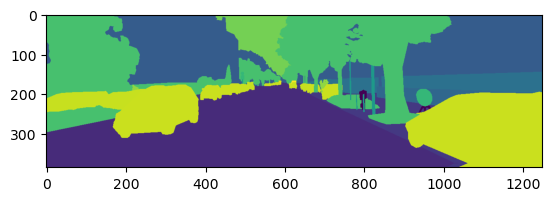

In [5]:
import torch
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import torch.nn.functional as F


def kitti_pad_transform(image: torch.Tensor) -> torch.Tensor:
    """
    Pad KITTI images (375x1242) to the next multiple of 32 (384x1248).
    Works for both single images [C, H, W] and batches [N, C, H, W].

    Input: h=375, w=1242

    Target: h=384, w=1248

    Padding: bottom=9, right=6

    Output shape: 384×1248 ✅ divisible by 32

    """

    # -2: slices the last two dimensions of the shape tuple.

    # Regardless of batch, the last two dimensions are always (H, W).
    # # Single image
    # image = torch.randn(3, 375, 1242)
    # print(image.shape[-2:])   # (375, 1242)

    # # Batch of images
    # batch = torch.randn(4, 3, 375, 1242)
    # print(batch.shape[-2:])   # (375, 1242)

    h, w = image.shape[-2:]  # Expect [C, H, W] or [H, W]

    # Compute target dims (next multiple of 32)
    target_h = ((h + 31) // 32) * 32  # ceil to multiple of 32
    target_w = ((w + 31) // 32) * 32

    pad_h = target_h - h
    pad_w = target_w - w

    # Order = (left, right, top, bottom)
    image = F.pad(image, (0, pad_w, 0, pad_h), mode='reflect')
    return image


pil_image = Image.open(image_path)
transform = transforms.ToTensor()
image = transform(pil_image)
image_padded = kitti_pad_transform(image)
print("image:",image.shape)
print("image padded:",image_padded.shape)

inv_transform = transforms.ToPILImage()
plt.imshow(inv_transform(image_padded))
# plt.imshow(pil_image)
plt.show()


In [6]:
def _build_id_to_trainid_lut(ignore_index: int = 255) -> np.ndarray:
    """
    Build a lookup table (LUT) to map raw 'id' values from KITTI/Cityscapes label images
    into the compact 'trainId' values used for training.

    Args:
        ignore_index: the value to assign when no valid mapping exists.
                      By convention in KITTI/Cityscapes, this is 255 (ignored in loss/eval).

    Returns:
        lut: a NumPy array of shape (256,), dtype=uint8,
             where lut[id] == trainId for all possible id values in [0,255].
             This lets us remap an entire mask with one vectorized call:
             train_mask = lut[id_mask]
    """
    # 1. Initialize LUT with all entries = ignore_index (default: 255).
    #    So if an 'id' is not listed in the label definitions,
    #    it will automatically map to ignore (safe default).
    lut = np.full(256, ignore_index, dtype=np.uint8)

    # 2. Fill in known mappings using the devkit label definitions.
    #    Each label has fields: name, id, trainId, category, ...
    for lab in LABELS:
        if 0 <= lab.id <= 255:     # only valid IDs
            lut[lab.id] = lab.trainId

    # 3. Return LUT: direct array index gives you the trainId.
    return lut


---

* **KITTI labels** (like Cityscapes) have:

  * `id` → the raw value stored in label PNGs (e.g. `26` for car, `7` for road).
  * `trainId` → the compact label used for training (0..18 for valid classes, 255 = ignore).

* When you load a label PNG with `PIL`/`numpy`, you get a 2D array of **ids**.
  You need to **map every pixel’s id → trainId** before feeding it to a network.

* A **lookup table (LUT)** makes this mapping very fast.

---



In [7]:
from utils.devkit.helpers.labels import labels as LABELS

lut = _build_id_to_trainid_lut()

# Suppose a mask pixel has raw id=26 (car).
print("trainId for car (id=26):", lut[26])  # e.g., 13


trainId for car (id=26): 13


In [8]:
from typing import Tuple

def _pad_to_multiple(img_t: torch.Tensor, mask_t: torch.Tensor, multiple: int = 32, ignore_index: int = 255) -> Tuple[torch.Tensor, torch.Tensor]:
    """Pad image (reflect) and mask (constant=ignore_index) to next multiple of `multiple`."""
    h, w = img_t.shape[-2:]
    th = ((h + multiple - 1) // multiple) * multiple
    tw = ((w + multiple - 1) // multiple) * multiple
    ph, pw = th - h, tw - w
    if ph == 0 and pw == 0:
        return img_t, mask_t
    # pad = (left, right, top, bottom) — push to right/bottom
    img_t = F.pad(img_t,  (0, pw, 0, ph), mode="reflect")
    mask_t = F.pad(mask_t, (0, pw, 0, ph), mode="constant", value=ignore_index)
    return img_t, mask_t

* In **semantic segmentation**, the **mask** (or label map) is a 2D tensor `[H, W]` where each pixel contains the **class label**.
* Example:

  * pixel = `0` → road
  * pixel = `1` → sidewalk
  * pixel = `13` → car
  * pixel = `255` → ignore (void, unlabeled, ego-vehicle, etc.)

So  `mask_t` is the **label for every pixel**.

---

####  Why pad image and mask together?

* When we pad an image to a larger size, we must **pad the mask identically** so that:

  * the pixel `(i, j)` in the image corresponds to the same `(i, j)` in the mask.
  * otherwise your training labels wouldn’t align with the image data.

So `_pad_to_multiple` takes **both image & mask** and applies the **same spatial padding**.

---

#### Why different padding modes?

* **Image (RGB): `reflect` padding**

  * Images are continuous signals.
  * If we just padded with black (0), the network would see artificial dark borders not present in real data.
  * Reflection padding "mirrors" the border pixels, which preserves local texture and avoids artifacts.

* **Mask (labels): `constant` padding with `ignore_index = 255`**

  * Masks are **categorical**, not continuous.
  * Reflection would *duplicate class labels* at the boundary → wrong labels!
    Example: if the last pixel was "car", reflection would create a fake car label outside the image.
  * Instead, we want the model to **ignore padded areas during training**.
  * That’s why we fill with `255` (the ignore index), so those pixels are excluded from the loss/eval.

---

#### Visual analogy

* **Image padding (reflect):**

```
... | road road road [road]
... | road road road [road]
```

or in the pixels:

```
original image edge: [  120 | 123 ]
reflection padding:  [ 123 | 120 | 123 | 120 ... ]

```

→ Edges extend smoothly.

* **Mask padding (constant=255):**

```
... | road road road [IGNORE]
... | road road road [IGNORE]
```

→ Padded region has no ground truth, so the model isn’t penalized for it.

---



#### `ignore_index=255` in Loss Functions

**Setup: model output vs. ground truth mask**

In **semantic segmentation**, your model outputs logits of shape:

```
[batch_size, num_classes, H, W]
```

Example: `[4, 19, 384, 1248]` for KITTI with 19 classes.

Your **ground truth mask** is:

```
[batch_size, H, W]
```

Each pixel contains the **trainId** (`0..18` for valid classes, `255` for ignore).

---

**CrossEntropyLoss with ignore\_index**

PyTorch’s `nn.CrossEntropyLoss` compares each pixel’s prediction to its ground truth label.
But if that label == `ignore_index`, it skips that pixel completely.

```python
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=255)
```

---


```python
# Suppose we have 1 image, 3 classes (road=0, car=1, person=2)
logits = torch.randn(1, 3, 2, 2, requires_grad=True)  # [N,C,H,W]

# Ground truth mask with one "ignore" pixel
target = torch.tensor([
    [ [0, 1],
      [2, 255] ]  # bottom-right = ignore
])  # [N,H,W]
```

Loss:

```python
loss = criterion(logits, target)
print("Loss:", loss.item())
```



* Top-left pixel → compared against class `0` (road).
* Top-right pixel → compared against class `1` (car).
* Bottom-left pixel → compared against class `2` (person).
* Bottom-right pixel → `255` → **ignored** in loss computation.

So the loss is averaged over **3 pixels only**, not 4.

---


### Recommended Datasets for Segmentation with U-Net  


| Dataset | Description | # Images (Train/Val/Test) | Classes | Best For | Download Link |
|---------|-------------|---------------------------|---------|----------|---------------|
| **Cityscapes** | High-quality urban street scenes (pixel-precise annotations). **Top recommendation** for your driving-themed U-Net. | 2,975 / 500 / 1,525 | 19 (e.g., road, car, person) | Autonomous driving segmentation | [Cityscapes Dataset](https://www.cityscapes-dataset.com/) |
| **Oxford-IIIT Pet** | Close-up pet images with fine-grained masks. Used in official Keras/TensorFlow U-Net tutorials. | ~3,680 / 368 / 3,669 | 37 breeds (binary: pet vs. background) | Beginner-friendly, precise boundaries | [TFDS or Official](https://www.robots.ox.ac.uk/~vgg/data/pets/) |
| **Pascal VOC 2012** | Everyday objects in natural scenes. Classic for segmentation benchmarks. | 1,464 / 1,449 / - | 20 (e.g., person, car, chair) | General object segmentation | [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) |
| **COCO (2017)** | Large-scale everyday scenes with instance masks (convert to semantic). | 118K / 5K / 40K | 80 (e.g., person, traffic light) | Diverse, large-scale training | [COCO Dataset](https://cocodataset.org/) |
| **ADE20K** | Indoor/outdoor scenes with detailed parts (e.g., wall, floor). | 20K / 2K / 3K | 150 | Scene parsing | [ADE20K](https://groups.csail.mit.edu/vision/datasets/ADE20K/) |


#### Encoder: Use It or Replace?
- **Use Your Custom Encoder**: **Yes, keep it!** It's a faithful implementation of the original U-Net contracting path (simple, lightweight, ~31M params with base=64). Great for from-scratch training on smaller datasets like Oxford Pets or KITTI subsets—no need for pretraining. It captures multi-scale features well for segmentation.
- **When to Replace**:
  - **For Better Performance**: Swap with a **pretrained backbone** (e.g., ResNet-34 or EfficientNet-B0) as the encoder. This adds transfer learning (ImageNet weights), boosting accuracy on limited data (e.g., KITTI's small annotations). U-Net variants like U-Net++ or DeepLab use this.
    - **How to Replace** (simple mod to your code):
      ```python
      import torchvision.models as models
      
      class UNetWithBackbone(nn.Module):
          def __init__(self, base=64, num_classes=19):  # e.g., Cityscapes classes
              super().__init__()
              # Pretrained encoder (extract features before final layers)
              self.encoder = models.resnet34(pretrained=True)
              self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove FC layers
              
              # Custom decoder (as before, but adjust in_channels to match ResNet outputs)
              # E.g., ResNet outputs: 64, 64, 128, 256, 512 → map to your skips
              self.D4upsample = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Adjust dims
              # ... rest of decoder
          
          def forward(self, x):
              # Extract skips from encoder
              x1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))  # 64ch
              x2 = self.encoder.layer1(x1)  # 64ch
              x3 = self.encoder.layer2(x2)  # 128ch
              x4 = self.encoder.layer3(x3)  # 256ch
              bottleneck = self.encoder.layer4(x4)  # 512ch
              
              # Decoder with skips (as before)
              # ...
      ```
    - **Benefits**: +5-10% mIoU on benchmarks; faster convergence. Use for Cityscapes/KITTI.
  - **Alternatives**: 
    - **No Change**: If dataset is small/simple (e.g., Oxford Pets), your encoder is perfect.
    - **Advanced**: Segment Anything Model (SAM) adapter for zero-shot, but overkill for full training.
- **Training Tip**: Use Dice + CrossEntropy loss for segmentation; augment with flips/rotations. Start with base=32 for faster prototyping.

This setup should get you training quickly—let me know if you need data loader code! 

Refs [1](https://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015)
         

## City Scapes

Refs: [1](https://github.com/mcordts/cityscapesScripts), [2](https://github.com/mcordts/cityscapesScripts)


## Segmentation Models 

Refs: [1](https://github.com/qubvel-org/segmentation_models.pytorch)

## Medical
For medical tasks, use **ISIC 2018** (skin lesions) or **Lung Nodule** datasets, as U-Net originated in biomedical imaging.


## RF-DETR: SOTA Real-Time Detection and Segmentation Model
Refs: [1](https://github.com/roboflow/rf-detr?tab=readme-ov-file)